In [1]:
#Parts of plotting script were provided from:
#https://github.com/aaronpmishkin/normalizing_flows/blob/master/experiments/logreg_example_planar.py

In [5]:
import torch
from torch.optim import Adam
from torch.distributions import MultivariateNormal
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal
from araNorm import araNorm
import sentencepiece as spm
import dill
from torchtext import data, datasets
import sentencepiece as spm

In [3]:
# Constants
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = False
MAX_LEN = 60
MIN_FREQ=1
DEVICE=torch.device('cuda') # not a big fan of this ...
print("you are not using CUDA right now!!!!!!")
USE_CUDA=False 

you are not using CUDA right now!!!!!!


In [4]:
#terrible decision making on my part....but we can fix it after deadline
def bpe_tokenize(text, model, transform=None):
    if transform is not None:
        text = transform(text)
    return model.EncodeAsPieces(text.strip())

def filter_fn(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN


def getBPE(src_pth, trg_pth):
    src_bpe = spm.SentencePieceProcessor()
    src_bpe.Load(src_pth)
    trg_bpe = spm.SentencePieceProcessor()
    trg_bpe.Load(trg_pth)

    src_transform = None
    trg_transform = None

    src_m = src_pth.split('/')[-1]
    trg_m = trg_pth.split('/')[-1]
    if 'arabic' in src_m:
        arab_norm = araNorm()
        src_transform = lambda x: arab_norm.run(x) 

    if 'arabic' in trg_m:
        arab_norm = araNorm()
        trg_transform = lambda x: arab_norm.run(x)

    src_tokenizer = lambda x: bpe_tokenize(x, src_bpe, src_transform)
    trg_tokenizer = lambda x: bpe_tokenize(x, trg_bpe, trg_transform)
    return src_tokenizer, trg_tokenizer



In [14]:
pth = '../.results/IWSLT_en-de/vaenmt_cond-planar_1_kl-anneal_80000.0_q_p_latents_256_particles_1_attn_True/'
pth = pth + 'validate-latent_spaces.pth'

sentence_pairs = torch.load(pth)
print(sentence_pairs.keys())
samples = sentence_pairs[1]
src = samples['src']
trg = samples['trg']
samples_dict = samples['sampes']

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])


(400,)
(400,)


NameError: name 'flow_type' is not defined

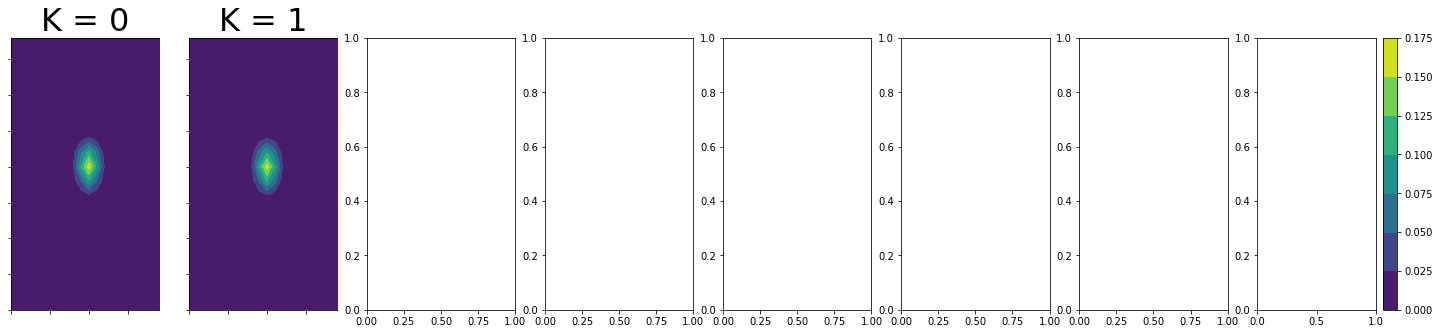

In [18]:
# Plot normalizing flow posterior:

grid_spacing = 1.0#0.5
spacing =10
w1, w2 = np.mgrid[-spacing:spacing:grid_spacing, -spacing:spacing:grid_spacing]
# Compute all combinations of w1 and w2 values from the grid.
W = np.squeeze(np.dstack((w1.reshape(w1.size), w2.reshape(w2.size))))

W_tensor = torch.tensor(W).to(torch.float)
fig, (ax) = plt.subplots(1, 8, figsize=(25, 5))
#fig.suptitle('{}'.format("Planar Flows"), size=24)
print( ax)
len(samples_dict.keys())
for i in range(len(samples_dict)):
    
#samples, log_probs = model.forward(num_samples=10000)
#samples = Normal(torch.ones(10000, 2) * 4, torch.ones(10000, 2) * 2).sample()

    samples = samples_dict['z_{}'.format(i)][:, 0:2]
    samples = samples.T

    kernel = stats.gaussian_kde(samples)

    Z = kernel(W.T)
    print(Z.shape)
    Z = Z.reshape((w1.shape[0], w2.shape[0]))
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    
    contour = ax[i].contourf(w1, w2, Z)
    ax[i].set_title("K = {}".format(i), size=32)
fig.colorbar(contour, ax=ax[-1])
plt.savefig("{}_flows_plot.pdf".format(flow_type), dpi=500)
plt.show()


In [8]:
src_bpe = './bpe_models/german.model'
trg_bpe = './bpe_models/de_english.model'
source= 'de'
target= 'en'

tokenize_src, tokenize_trg = getBPE(src_bpe, trg_bpe)


data_save_path = './data_{}_to_{}.pth'.format(source, target) 
datahandler = DataHandler(tokenize_src, tokenize_trg, LOWER, EOS_TOKEN, SOS_TOKEN, PAD_TOKEN, UNK_TOKEN, MIN_FREQ, DEVICE)

fields = [('src', datahandler.getSRCField()), ('trg', datahandler.getTRGField())]
f = torch.load(data_save_path, pickle_module=dill)
print('found previous saved train and valid data, delete if undesired')
datahandler.load_vocabs(f['src_vocab'], f['trg_vocab'])
train_data= data.Dataset(f['train_examples'], fields=fields, filter_pred=None)
valid_data = data.Dataset(f['valid_examples'], fields=fields, filter_pred=None) 
test_data = data.Dataset(f['test_examples'], fields=fields, filter_pred=None) #this is temporary


#test_data = data.Dataset(f['test_examples'], fields=fields, filter_pred=None)

found previous saved train and valid data, delete if undesired


In [9]:
print(f.keys())
print(len(datahandler.getSRCVocab()), len(datahandler.getTRGVocab()))
len(f['trg_vocab'])



dict_keys(['train_examples', 'valid_examples', 'test_examples', 'src_vocab', 'trg_vocab'])
19926 19559


19559

In [98]:
# Stuff to handle loading the model 
#flow_type='iaf'
#num_flows=8
#epoch=9

flow_type='planar'
num_flows=8
epoch=8

name='{}_num_flows_{}_de_en_model_epoch_{}.pth'.format(flow_type, num_flows, epoch)
model_pth ='./models/{}'.format(name)
model_type='vnmt'
z_dim=2 #it will have to be 2 in order to plot
model = make_model(len(datahandler.getSRCVocab()), len(datahandler.getTRGVocab()),
        type=model_type, emb_size=300, hidden_size=256 , num_layers=2, dropout=0.5, z_layer=z_dim)

#Setup Flow stuff


if flow_type == 'planar':
    model.loadPlanarFlows(num_flows, z_dim=z_dim)
elif flow_type == 'iaf':
    model.loadIAFs(num_flows, z_dim=z_dim)

#print(model)
#print(model.nf_modules[0].u)
#print(model.nf_modules[15].u)
#print(model.nf_modules[27].u)
prev =0.0
#for i in range(0, 10):
#    model_pth = './models/{}_num_flows_{}_de_en_model_epoch_{}.pth'.format(flow_type, num_flows, i)
#    model.load(model_pth)
#    curr = model.nf_modules[0].arn.layers[1].weight[0]
    #curr = model.nf_modules[0].u
#    print(prev - curr)
#    prev = curr.clone()
    #print(prev - model.nf_modules[0].arn.layers[1].weight[0])
    #prev = model.nf_modules[0].arn.layers[1].weight[0]
model.load(model_pth)
print(model)
model.eval()
#print(model.nf_modules[0].u)
#print(model.nf_modules[15].u)
#print(model.nf_modules[27].u)

VariationalEncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(814, 256, num_layers=2, batch_first=True, dropout=0.5)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.5)
    (pre_output_layer): Linear(in_features=1070, out_features=256, bias=False)
  )
  (src_embed): Embedding(19926, 300)
  (trg_embed): Embedding(19559, 300)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=19559, bias=False)
  )
  (prior): GaussLayer(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=2, bia

VariationalEncoderDecoder(
  (encoder): Encoder(
    (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (key_layer): Linear(in_features=512, out_features=256, bias=False)
      (query_layer): Linear(in_features=256, out_features=256, bias=False)
      (energy_layer): Linear(in_features=256, out_features=1, bias=False)
    )
    (rnn): GRU(814, 256, num_layers=2, batch_first=True, dropout=0.5)
    (bridge): Linear(in_features=512, out_features=256, bias=True)
    (dropout_layer): Dropout(p=0.5)
    (pre_output_layer): Linear(in_features=1070, out_features=256, bias=False)
  )
  (src_embed): Embedding(19926, 300)
  (trg_embed): Embedding(19559, 300)
  (generator): Generator(
    (proj): Linear(in_features=256, out_features=19559, bias=False)
  )
  (prior): GaussLayer(
    (linear): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=2, bia

In [99]:
if USE_CUDA:
    model = model.cuda()
else:
    model = model.cpu()

# Generate the samples from the flows
pad_index = datahandler.getTRGVocab().stoi[PAD_TOKEN]
test_iter = datahandler.getIter(test_data, batch_size=1, train=False, sort=False, repeat=False) 
#Get the first sentence
for sentence in test_iter:
    batch = rebatch(pad_index, sentence, use_cuda=USE_CUDA)
    break

src, src_mask, src_lengths = batch.src, batch.src_mask, batch.src_lengths
trg, trg_mask, trg_lengths = batch.trg, batch.trg_mask, batch.trg_lengths

if not USE_CUDA:
    src, src_mask, src_lengths = src.cpu(), src_mask.cpu(), src_lengths.cpu()
    trg, trg_mask, trg_lengths = trg.cpu(), trg_mask.cpu(), trg_lengths.cpu()
#encode the variational distribution
encoder_hidden_x, encoder_final = model.encoder(model.src_embed(src), src_mask, src_lengths)
encoder_hidden_y, _ = model.encoder(model.trg_embed(trg), trg_mask, trg_lengths, pad_pack=False)

#mean pooling operation
X = model.meanPool(encoder_hidden_x, src_lengths)
Y = model.meanPool(encoder_hidden_y, trg_lengths)
        
z = torch.cat([X, Y], dim=1)
#TODO there...might need to be another layer in here
z_mean, z_sig = model.posterior(z)
print(z_mean.size())
print(z_mean)
print(z_sig)
#z_mean = z_mean[0,:2]
#z_sig = z_sig[0, :2]

num_samples = 100000


samples_dict = {i: Normal(torch.ones(10000, 2) * z_mean, torch.ones(10000, 2) * z_sig).sample() for i in range(len(model.nf_modules))}
for i, n in enumerate(model.nf_modules):
    transform = n(samples_dict[i])
    #print(transform.size())
    samples_dict[i] = transform



torch.Size([1, 2])
tensor([[-2.8368,  1.3742]], grad_fn=<AddmmBackward>)
tensor([[3.1194, 1.9965]], grad_fn=<SoftplusBackward>)


In [103]:
src = test_data[0].src
trg = test_data[0].trg
print(src)
print(trg)
def loadBPEModel(m):
    sp = spm.SentencePieceProcessor()
    sp.Load(m + '.model')
    return sp

src_bpe = loadBPEModel('./bpe_models/german')
trg_bpe = loadBPEModel('./bpe_models/de_english')

src = src_bpe.DecodePieces(src)
trg = trg_bpe.DecodePieces(trg)
print(src)
print(trg)

['▁Als', '▁ich', '▁in', '▁meinen', '▁20', 'ern', '▁war', ',', '▁hatte', '▁ich', '▁meine', '▁erste', '▁Psych', 'otherapie', '-', 'P', 'at', 'ient', 'in', '.']
['▁When', '▁I', '▁was', '▁in', '▁my', '▁20', 's', ',', '▁I', '▁saw', '▁my', '▁very', '▁first', '▁psychotherapy', '▁client', '.']
Als ich in meinen 20ern war, hatte ich meine erste Psychotherapie-Patientin.
When I was in my 20s, I saw my very first psychotherapy client.


In [ ]:
# Plot "True" Posterior (computed numerically) 
#We do not have this, if we did this would be much easier

f = W @ X_np.T

log_prior = np.log(stats.multivariate_normal(mean=torch.zeros(2).numpy(), cov=torch.eye(2).div(prior_prec).numpy()).pdf(W))
prior = np.exp(log_prior)

log_like = np.sum(f * np.squeeze(y_np) - np.log(1+np.exp(f)), 1)
log_joint = log_like + log_prior
joint = np.exp(log_joint)

# Simple approximation of the Trapezoidal Rule.
log_marginal = np.log((grid_spacing**2) * np.sum(np.exp(log_joint)))

log_post = log_joint - log_marginal
post = np.exp(log_post)

# Reshape the densities back into a grid.
prior_density = prior.reshape((w1.shape[0], w2.shape[0]))
joint_density = joint.reshape((w1.shape[0], w2.shape[0]))
posterior_density = post.reshape((w1.shape[0], w2.shape[0]))

fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))
c1 = vis.plot_density(ax1, w1, w2, posterior_density, title="Posterior", xlim=[-2,10], ylim=[-2,10])

